# データの取得と保存

In [ ]:
import requests
from bs4 import BeautifulSoup
import time
import random
import sqlite3
import re
import os
from datetime import datetime
from urllib.parse import urljoin

class JalanScraper:
    def __init__(self):
        """スクレイパーの初期化"""
        self.base_url = "https://www.jalan.net"
        
        # ブラウザをエミュレートするヘッダー
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
            'Accept-Language': 'ja-JP,ja;q=0.9,en-US;q=0.8,en;q=0.7',
            'Accept-Encoding': 'gzip, deflate, br',
            'Connection': 'keep-alive',
            'Referer': 'https://www.jalan.net/',
            'Upgrade-Insecure-Requests': '1',
            'Cache-Control': 'max-age=0',
            'sec-ch-ua': '" Not A;Brand";v="99", "Chromium";v="96", "Google Chrome";v="96"',
            'sec-ch-ua-mobile': '?0',
            'sec-ch-ua-platform': '"Windows"'
        }
        
        self.session = requests.Session()
        self.session.headers.update(self.headers)
        
        self.db_path = "jalan_travel_data.db"
        self.initialize_db()
        
        # URL構造の定義
        self.kankou_url_patterns = [
            "https://www.jalan.net/kankou/cit_{pref_code}0000/",
            "https://www.jalan.net/kankou/pre_{pref_code}00/",
            "https://www.jalan.net/kankou/{pref_code}/",
            "https://www.jalan.net/kankou/pro_{pref_code}/",
            "https://www.jalan.net/{pref_code}_kankou/"
        ]
        
        self.hotel_url_patterns = [
            "https://www.jalan.net/area/{pref_name}/",
            "https://www.jalan.net/{pref_name}/",
            "https://www.jalan.net/yad/search/to/prm_{pref_code}/"
            "https://www.jalan.net/ryokan{pref_code}/"
        ]
        
        # 都道府県名のマッピング
        self.prefecture_name_map = {
            '13': 'tokyo',
            '26': 'kyoto',
            '27': 'osaka'
        }
        
        # ログ制御フラグ
        self.verbose = False
    
    def initialize_db(self):
        """データベースとテーブルの初期化"""
        conn = sqlite3.connect(self.db_path)
        cursor = conn.cursor()
        
        # 観光地情報テーブル
        cursor.execute('''
        CREATE TABLE IF NOT EXISTS tourist_spots (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            name TEXT,
            prefecture TEXT,
            prefecture_code TEXT,
            category TEXT,
            rating REAL,
            review_count INTEGER,
            address TEXT,
            access_info TEXT,
            nearest_station TEXT,
            station_distance TEXT,
            recommended_seasons TEXT,
            description TEXT,
            spot_url TEXT,
            image_url TEXT,
            scraped_at TIMESTAMP
        )
        ''')
        
        # 宿泊施設テーブル
        cursor.execute('''
        CREATE TABLE IF NOT EXISTS accommodations (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            name TEXT,
            prefecture TEXT,
            prefecture_code TEXT,
            area TEXT,
            address TEXT,
            rating REAL,
            review_count INTEGER,
            min_price REAL,
            max_price REAL,
            hotel_type TEXT,
            distance_to_station TEXT,
            nearby_spots TEXT,
            facility_features TEXT,
            hotel_url TEXT,
            image_url TEXT,
            scraped_at TIMESTAMP
        )
        ''')
        
        conn.commit()
        conn.close()
        print("データベース初期化完了")

    def get_prefecture_code_map(self):
        """都道府県コードとその名前のマッピング"""
        return {
            '1': '北海道', '2': '青森県', '3': '岩手県', '4': '宮城県', '5': '秋田県',
            '6': '山形県', '7': '福島県', '8': '茨城県', '9': '栃木県', '10': '群馬県',
            '11': '埼玉県', '12': '千葉県', '13': '東京都', '14': '神奈川県', '15': '新潟県',
            '16': '富山県', '17': '石川県', '18': '福井県', '19': '山梨県', '20': '長野県',
            '21': '岐阜県', '22': '静岡県', '23': '愛知県', '24': '三重県', '25': '滋賀県',
            '26': '京都府', '27': '大阪府', '28': '兵庫県', '29': '奈良県', '30': '和歌山県',
            '31': '鳥取県', '32': '島根県', '33': '岡山県', '34': '広島県', '35': '山口県',
            '36': '徳島県', '37': '香川県', '38': '愛媛県', '39': '高知県', '40': '福岡県',
            '41': '佐賀県', '42': '長崎県', '43': '熊本県', '44': '大分県', '45': '宮崎県',
            '46': '鹿児島県', '47': '沖縄県'
        }

    def get_page(self, url, retry=3):
        """ページを取得してBeautifulSoupオブジェクトを返す"""
        for attempt in range(retry):
            try:
                sleep_time = random.uniform(1, 3)
                time.sleep(sleep_time)
                
                # ユーザーエージェントをランダムに切り替え
                user_agents = [
                    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36',
                    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.0 Safari/605.1.15',
                    'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:94.0) Gecko/20100101 Firefox/94.0',
                    'Mozilla/5.0 (iPhone; CPU iPhone OS 15_0 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.0 Mobile/15E148 Safari/604.1'
                ]
                self.session.headers.update({'User-Agent': random.choice(user_agents)})
                
                response = self.session.get(url, timeout=30)
                
                # ステータスコードチェック
                if response.status_code == 200:
                    return BeautifulSoup(response.content, 'html.parser')
                else:
                    if self.verbose:
                        print(f"HTTP エラー：{response.status_code} - {url}")
                    
            except requests.exceptions.RequestException as e:
                if self.verbose:
                    print(f"リクエストエラー ({attempt+1}/{retry})：{url} - {e}")
            except Exception as e:
                if self.verbose:
                    print(f"予期せぬエラー ({attempt+1}/{retry})：{url} - {e}")
            
            # リトライ
            if attempt < retry - 1 and self.verbose:
                print("リトライ中...")
                time.sleep(2)
        
        return None

    def find_working_url(self, patterns, pref_code, pref_name=None):
        """複数のURL形式から働くものを検索"""
        if not pref_name and pref_code in self.prefecture_name_map:
            pref_name = self.prefecture_name_map[pref_code]
        
        for pattern in patterns:
            try:
                if '{pref_code}' in pattern:
                    url = pattern.format(pref_code=pref_code)
                elif '{pref_name}' in pattern and pref_name:
                    url = pattern.format(pref_name=pref_name)
                else:
                    continue
                    
                response = self.session.head(url, timeout=10)
                if response.status_code == 200:
                    return url
            except Exception:
                pass
        
        return None

    def try_all_page_formats(self, base_url, page):
        """異なるページネーション形式をすべて試す"""
        if page == 1:
            return [base_url]
        
        # 様々なページネーション形式
        formats = [
            f"{base_url}?page={page}",
            f"{base_url.rstrip('/')}/?page={page}",
            f"{base_url}page_{page}.html",
            f"{base_url.rstrip('/')}/page_{page}/",
            f"{base_url.rstrip('/')}/page={page}/",
            f"{base_url.rstrip('/')}/index_{page}.html",
        ]
        
        return formats

    def scrape_tourist_spots(self, prefecture_code, pages=2):
        """都道府県ごとの観光地情報をスクレイピング"""
        prefecture_name = self.get_prefecture_code_map().get(prefecture_code, "不明")
        pref_name_roman = self.prefecture_name_map.get(prefecture_code, "")
        
        spots_data = []
        
        # 有効なURLを探す
        base_url = self.find_working_url(self.kankou_url_patterns, prefecture_code, pref_name_roman)
        
        if not base_url:
            # ディレクトリブラウジングを試す
            discovery_url = f"https://www.jalan.net/kankou/"
            soup = self.get_page(discovery_url)
            if soup:
                links = soup.find_all('a')
                for link in links:
                    href = link.get('href', '')
                    if prefecture_code in href or (pref_name_roman and pref_name_roman.lower() in href.lower()):
                        potential_url = urljoin(discovery_url, href)
                        if self.session.head(potential_url).status_code == 200:
                            base_url = potential_url
                            break
        
        if not base_url:
            print(f"{prefecture_name}の観光地情報：URL検出失敗")
            return []
        
        print(f"{prefecture_name}の観光地情報：スクレイピング開始")
        
        collected_items_count = 0
        
        for page in range(1, pages + 1):
            page_formats = self.try_all_page_formats(base_url, page)
            page_fetched = False
            page_items_count = 0
            
            for page_url in page_formats:
                soup = self.get_page(page_url)
                if not soup:
                    continue
                
                # 様々なリストコンテナセレクタを試す
                selectors = [
                    '.p-searchResultItems .p-searchResultItem',  # 新UI
                    '.item-listContents',                        # 旧UI
                    '.spotList li',                              # 別の形式
                    '.kanko_box',                                # さらに別の形式
                    '.list_item',                                # 汎用的なリスト項目
                    '.spot-card',                                # カード形式
                    'article.spot'                               # 記事形式
                ]
                
                for selector in selectors:
                    spot_elements = soup.select(selector)
                    if spot_elements:
                        page_fetched = True
                        
                        for spot in spot_elements:
                            try:
                                # 名前取得のための複数のセレクタを試す
                                name_selectors = [
                                    '.item-name a', '.p-searchResultItem__name a', 
                                    '.spot-name a', 'h3 a', '.title a', '.name'
                                ]
                                name_element = None
                                for name_selector in name_selectors:
                                    name_element = spot.select_one(name_selector)
                                    if name_element:
                                        break
                                
                                if not name_element:
                                    # リンク要素だけを探す
                                    links = spot.find_all('a')
                                    for link in links:
                                        if link.text.strip() and 'href' in link.attrs:
                                            name_element = link
                                            break
                                
                                if not name_element:
                                    # 見出し要素を探す
                                    headings = spot.find_all(['h2', 'h3', 'h4'])
                                    if headings:
                                        name_element = headings[0]
                                
                                if not name_element:
                                    continue
                                
                                name = name_element.text.strip()
                                
                                # URL取得
                                detail_url = None
                                if hasattr(name_element, 'href'):
                                    detail_url = name_element['href']
                                elif name_element.parent and name_element.parent.name == 'a':
                                    detail_url = name_element.parent['href']
                                elif name_element.find('a'):
                                    detail_url = name_element.find('a')['href']
                                
                                if detail_url and not detail_url.startswith('http'):
                                    detail_url = urljoin(self.base_url, detail_url)
                                
                                # カテゴリ情報
                                category_selectors = [
                                    '.item-cate', '.p-searchResultItem__category', 
                                    '.category', '.spot-category', '.genre'
                                ]
                                category = "不明"
                                for cat_sel in category_selectors:
                                    cat_elem = spot.select_one(cat_sel)
                                    if cat_elem:
                                        category = cat_elem.text.strip()
                                        break
                                
                                # 評価
                                rating_selectors = [
                                    '.item-evaluateNumber', '.p-searchResultItem__ratingValue', 
                                    '.rating', '.score', '.star-rating'
                                ]
                                rating = None
                                for rate_sel in rating_selectors:
                                    rate_elem = spot.select_one(rate_sel)
                                    if rate_elem:
                                        rating_text = rate_elem.text.strip()
                                        rating_match = re.search(r'(\d+\.\d+)', rating_text)
                                        if rating_match:
                                            rating = float(rating_match.group(1))
                                            break
                                
                                # レビュー数
                                review_selectors = [
                                    '.item-evaluateCount', '.p-searchResultItem__ratingCount', 
                                    '.reviews', '.review-count'
                                ]
                                review_count = None
                                for rev_sel in review_selectors:
                                    rev_elem = spot.select_one(rev_sel)
                                    if rev_elem:
                                        review_text = rev_elem.text.strip()
                                        review_match = re.search(r'(\d+)', review_text)
                                        if review_match:
                                            review_count = int(review_match.group(1))
                                            break
                                
                                # 画像URL
                                image_url = ""
                                img_element = spot.select_one('img')
                                if img_element and 'src' in img_element.attrs:
                                    image_url = img_element['src']
                                    if not image_url.startswith('http'):
                                        image_url = urljoin(self.base_url, image_url)
                                
                                # 基本情報のみ（詳細データは省略）
                                address = "情報なし"
                                access_info = "情報なし"
                                nearest_station = "情報なし"
                                station_distance = "情報なし"
                                recommended_seasons = "春,夏,秋,冬"
                                description = "情報なし"
                                
                                # データ構造に格納
                                spot_info = {
                                    'name': name,
                                    'prefecture': prefecture_name,
                                    'prefecture_code': prefecture_code,
                                    'category': category,
                                    'rating': rating,
                                    'review_count': review_count,
                                    'address': address,
                                    'access_info': access_info,
                                    'nearest_station': nearest_station,
                                    'station_distance': station_distance,
                                    'recommended_seasons': recommended_seasons,
                                    'description': description,
                                    'spot_url': detail_url,
                                    'image_url': image_url,
                                    'scraped_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                                }
                                
                                spots_data.append(spot_info)
                                page_items_count += 1
                                collected_items_count += 1
                            
                            except Exception as e:
                                if self.verbose:
                                    print(f"観光地データ処理エラー：{e}")
                                continue
                        
                        break  # セレクタが見つかったのでループを抜ける
                
                if page_fetched:
                    print(f"{prefecture_name}の観光地情報：ページ{page}から{page_items_count}件取得")
                    break  # このページのデータ取得成功
        
        # データベースに保存
        if spots_data:
            self.save_to_db(spots_data, 'tourist_spots')
            print(f"{prefecture_name}の観光地情報：合計{collected_items_count}件をDBに保存")
        else:
            print(f"{prefecture_name}の観光地情報：データ取得なし")
        
        return spots_data

    def scrape_accommodations(self, prefecture_code, pages=2):
        """都道府県ごとの宿泊施設情報をスクレイピング"""
        prefecture_name = self.get_prefecture_code_map().get(prefecture_code, "不明")
        pref_name_roman = self.prefecture_name_map.get(prefecture_code, "")
        
        accommodations_data = []
        
        # 有効なURLを探す
        base_url = self.find_working_url(self.hotel_url_patterns, prefecture_code, pref_name_roman)
        
        if not base_url:
            # ディレクトリブラウジングを試す
            discovery_url = f"https://www.jalan.net/ryokan/"
            soup = self.get_page(discovery_url)
            if soup:
                links = soup.find_all('a')
                for link in links:
                    href = link.get('href', '')
                    if prefecture_code in href or (pref_name_roman and pref_name_roman.lower() in href.lower()):
                        potential_url = urljoin(discovery_url, href)
                        if self.session.head(potential_url).status_code == 200:
                            base_url = potential_url
                            break
        
        if not base_url:
            print(f"{prefecture_name}の宿泊施設情報：URL検出失敗")
            return []
        
        print(f"{prefecture_name}の宿泊施設情報：スクレイピング開始")
        
        collected_items_count = 0
        
        for page in range(1, pages + 1):
            page_formats = self.try_all_page_formats(base_url, page)
            page_fetched = False
            page_items_count = 0
            
            for page_url in page_formats:
                soup = self.get_page(page_url)
                if not soup:
                    continue
                
                # 宿検索結果の複数のセレクタパターンを試す
                selectors = [
                    '.p-searchResultItem',         # 新UI
                    '.item-listContents',          # 旧UI
                    '.hotel-item',                 # 別の形式
                    '.yadList li',                 # さらに別の形式
                    '.list_item',                  # 汎用的なリスト項目
                    '.hotel-card',                 # カード形式
                    'article.hotel'                # 記事形式
                ]
                
                for selector in selectors:
                    hotel_elements = soup.select(selector)
                    if hotel_elements:
                        page_fetched = True
                        
                        for hotel in hotel_elements:
                            try:
                                # 名前取得のための複数のセレクタを試す
                                name_selectors = [
                                    '.p-searchResultItem__facilityName a',
                                    '.item-name a',
                                    '.hotel-name a',
                                    'h3 a',
                                    '.title a',
                                    '.name'
                                ]
                                name_element = None
                                for name_selector in name_selectors:
                                    name_element = hotel.select_one(name_selector)
                                    if name_element:
                                        break
                                
                                if not name_element:
                                    # リンク要素を探す
                                    links = hotel.find_all('a')
                                    for link in links:
                                        if link.text.strip() and 'href' in link.attrs and ('/yad' in link['href'] or '/hotel' in link['href']):
                                            name_element = link
                                            break
                                
                                if not name_element:
                                    # 見出し要素を探す
                                    headings = hotel.find_all(['h2', 'h3', 'h4'])
                                    if headings:
                                        name_element = headings[0]
                                
                                if not name_element:
                                    continue
                                
                                name = name_element.text.strip()
                                
                                # URL取得
                                detail_url = None
                                if hasattr(name_element, 'href'):
                                    detail_url = name_element['href']
                                elif name_element.parent and name_element.parent.name == 'a':
                                    detail_url = name_element.parent['href']
                                elif name_element.find('a'):
                                    detail_url = name_element.find('a')['href']
                                
                                if detail_url and not detail_url.startswith('http'):
                                    detail_url = urljoin(self.base_url, detail_url)
                                
                                # エリア情報
                                area_selectors = [
                                    '.p-searchResultItem__area',
                                    '.item-area',
                                    '.hotel-area',
                                    '.area',
                                    '.location'
                                ]
                                area = "不明"
                                for area_sel in area_selectors:
                                    area_elem = hotel.select_one(area_sel)
                                    if area_elem:
                                        area = area_elem.text.strip()
                                        break
                                
                                # 評価
                                rating_selectors = [
                                    '.p-searchResultItem__ratingValue',
                                    '.item-evaluateNumber',
                                    '.rating',
                                    '.score',
                                    '.star-rating'
                                ]
                                rating = None
                                for rate_sel in rating_selectors:
                                    rate_elem = hotel.select_one(rate_sel)
                                    if rate_elem:
                                        rating_text = rate_elem.text.strip()
                                        rating_match = re.search(r'(\d+\.\d+)', rating_text)
                                        if rating_match:
                                            rating = float(rating_match.group(1))
                                            break
                                
                                # レビュー数
                                review_selectors = [
                                    '.p-searchResultItem__ratingCount',
                                    '.item-evaluateCount',
                                    '.reviews',
                                    '.review-count'
                                ]
                                review_count = None
                                for rev_sel in review_selectors:
                                    rev_elem = hotel.select_one(rev_sel)
                                    if rev_elem:
                                        review_text = rev_elem.text.strip()
                                        review_match = re.search(r'(\d+)', review_text)
                                        if review_match:
                                            review_count = int(review_match.group(1))
                                            break
                                
                                # 料金
                                price_selectors = [
                                    '.p-searchResultItem__lowestPrice',
                                    '.item-price',
                                    '.price',
                                    '.hotel-price',
                                    '.rate'
                                ]
                                min_price = None
                                max_price = None
                                for price_sel in price_selectors:
                                    price_elem = hotel.select_one(price_sel)
                                    if price_elem:
                                        price_text = price_elem.text.strip()
                                        price_matches = re.findall(r'(\d{1,3}(,\d{3})*)', price_text)
                                        if price_matches:
                                            price_values = [int(match[0].replace(',', '')) for match in price_matches]
                                            if price_values:
                                                min_price = min(price_values)
                                                max_price = max(price_values) if len(price_values) > 1 else min_price
                                                break
                                
                                # 画像URL
                                image_url = ""
                                img_element = hotel.select_one('img')
                                if img_element:
                                    for attr in ['src', 'data-src', 'data-original']:
                                        if attr in img_element.attrs:
                                            image_url = img_element[attr]
                                            if not image_url.startswith('http'):
                                                image_url = urljoin(self.base_url, image_url)
                                            break
                                
                                # 基本情報
                                hotel_type = "宿泊施設"
                                address = "情報なし"
                                distance_to_station = "情報なし"
                                nearby_spots = "情報なし"
                                facility_features = "情報なし"
                                
                                # データ構造に格納
                                accommodation_info = {
                                    'name': name,
                                    'prefecture': prefecture_name,
                                    'prefecture_code': prefecture_code,
                                    'area': area,
                                    'address': address,
                                    'rating': rating,
                                    'review_count': review_count,
                                    'min_price': min_price,
                                    'max_price': max_price,
                                    'hotel_type': hotel_type,
                                    'distance_to_station': distance_to_station,
                                    'nearby_spots': nearby_spots,
                                    'facility_features': facility_features,
                                    'hotel_url': detail_url,
                                    'image_url': image_url,
                                    'scraped_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                                }
                                
                                accommodations_data.append(accommodation_info)
                                page_items_count += 1
                                collected_items_count += 1
                            
                            except Exception as e:
                                if self.verbose:
                                    print(f"宿泊施設データ処理エラー：{e}")
                                continue
                        
                        break  # セレクタが見つかったのでループを抜ける
                
                if page_fetched:
                    print(f"{prefecture_name}の宿泊施設情報：ページ{page}から{page_items_count}件取得")
                    break  # このページのデータ取得成功
        
        # データベースに保存
        if accommodations_data:
            self.save_to_db(accommodations_data, 'accommodations')
            print(f"{prefecture_name}の宿泊施設情報：合計{collected_items_count}件をDBに保存")
        else:
            print(f"{prefecture_name}の宿泊施設情報：データ取得なし")
        
        return accommodations_data

    def save_to_db(self, data_list, table_name):
        """データをデータベースに保存"""
        if not data_list:
            return
            
        try:
            conn = sqlite3.connect(self.db_path)
            cursor = conn.cursor()
            
            if table_name == 'tourist_spots':
                for spot in data_list:
                    # SQLインジェクション防止のためパラメータ化クエリを使用
                    cursor.execute('''
                    INSERT INTO tourist_spots 
                    (name, prefecture, prefecture_code, category, rating, review_count, 
                     address, access_info, nearest_station, station_distance, 
                     recommended_seasons, description, spot_url, image_url, scraped_at) 
                    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                    ''', (
                        spot.get('name'), 
                        spot.get('prefecture'), 
                        spot.get('prefecture_code'),
                        spot.get('category'), 
                        spot.get('rating'), 
                        spot.get('review_count'),
                        spot.get('address'), 
                        spot.get('access_info'), 
                        spot.get('nearest_station'),
                        spot.get('station_distance'), 
                        spot.get('recommended_seasons'), 
                        spot.get('description'),
                        spot.get('spot_url'), 
                        spot.get('image_url'), 
                        spot.get('scraped_at')
                    ))
            
            elif table_name == 'accommodations':
                for hotel in data_list:
                    cursor.execute('''
                    INSERT INTO accommodations 
                    (name, prefecture, prefecture_code, area, address, rating, review_count,
                     min_price, max_price, hotel_type, distance_to_station, nearby_spots,
                     facility_features, hotel_url, image_url, scraped_at) 
                    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                    ''', (
                        hotel.get('name'), 
                        hotel.get('prefecture'), 
                        hotel.get('prefecture_code'),
                        hotel.get('area'), 
                        hotel.get('address'), 
                        hotel.get('rating'),
                        hotel.get('review_count'), 
                        hotel.get('min_price'), 
                        hotel.get('max_price'),
                        hotel.get('hotel_type'), 
                        hotel.get('distance_to_station'), 
                        hotel.get('nearby_spots'),
                        hotel.get('facility_features'), 
                        hotel.get('hotel_url'), 
                        hotel.get('image_url'),
                        hotel.get('scraped_at')
                    ))
            
            conn.commit()
            conn.close()
            
        except Exception as e:
            print(f"データベース保存エラー：{e}")
            if conn:
                conn.close()

    def check_database(self):
        """データベースの状態を確認"""
        try:
            conn = sqlite3.connect(self.db_path)
            cursor = conn.cursor()
            
            # 観光地データ数
            cursor.execute("SELECT COUNT(*) FROM tourist_spots")
            spots_count = cursor.fetchone()[0]
            
            # 宿泊施設データ数
            cursor.execute("SELECT COUNT(*) FROM accommodations")
            accommodations_count = cursor.fetchone()[0]
            
            # 都道府県別データ数
            cursor.execute("SELECT prefecture, COUNT(*) FROM tourist_spots GROUP BY prefecture")
            prefecture_counts = cursor.fetchall()
            
            conn.close()
            
            print(f"データベース状態：観光地 {spots_count}件、宿泊施設 {accommodations_count}件")
            for prefecture, count in prefecture_counts:
                print(f"  - {prefecture}：{count}件")
                
            return {
                'spots_count': spots_count,
                'accommodations_count': accommodations_count,
                'prefecture_counts': prefecture_counts
            }
            
        except Exception as e:
            print(f"データベース確認エラー：{e}")
            return None

    def execute(self, prefecture_codes=None, pages_per_prefecture=2):
        """指定された都道府県のデータをスクレイピング"""
        if prefecture_codes is None:
            # デフォルトで東京、京都、大阪
            prefecture_codes = ['13', '26', '27']
        
        start_time = datetime.now()
        print(f"スクレイピング開始：{start_time.strftime('%Y-%m-%d %H:%M:%S')}")
        
        for code in prefecture_codes:
            prefecture_name = self.get_prefecture_code_map().get(code, "不明")
            print(f"\n「{prefecture_name}」のデータ収集を開始します")
            
            # 観光地情報の取得
            self.scrape_tourist_spots(code, pages_per_prefecture)
            
            # 宿泊施設情報の取得
            self.scrape_accommodations(code, pages_per_prefecture)
        
        end_time = datetime.now()
        duration = end_time - start_time
        print(f"\nスクレイピング完了：{end_time.strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"処理時間：{duration.total_seconds():.1f}秒")
        print(f"データベースファイル：{self.db_path}")

# 実行コード
if __name__ == "__main__":
    # データベースファイルが存在する場合は削除して新規作成
    db_file = "jalan_travel_data.db"
    if os.path.exists(db_file):
        os.remove(db_file)
        print("既存のデータベースファイルを削除しました。")
    
    scraper = JalanScraper()
    
    # 東京、京都、大阪のデータをスクレイピング (各1ページ)
    target_prefectures = ['13', '26', '27']
    scraper.execute(prefecture_codes=target_prefectures, pages_per_prefecture=1)
    
    # データベース状態の確認
    scraper.check_database()

データベース初期化完了
スクレイピング開始：2026-01-27 22:14:18

「東京都」のデータ収集を開始します
東京都の観光地情報：スクレイピング開始
東京都の観光地情報：ページ1から30件取得
東京都の観光地情報：合計30件をDBに保存
東京都の宿泊施設情報：スクレイピング開始
東京都の宿泊施設情報：ページ1から30件取得
東京都の宿泊施設情報：合計30件をDBに保存

「京都府」のデータ収集を開始します
京都府の観光地情報：スクレイピング開始
京都府の観光地情報：ページ1から30件取得
京都府の観光地情報：合計30件をDBに保存
京都府の宿泊施設情報：スクレイピング開始
京都府の宿泊施設情報：ページ1から30件取得
京都府の宿泊施設情報：合計30件をDBに保存

「大阪府」のデータ収集を開始します
大阪府の観光地情報：スクレイピング開始
大阪府の観光地情報：ページ1から30件取得
大阪府の観光地情報：合計30件をDBに保存
大阪府の宿泊施設情報：スクレイピング開始
大阪府の宿泊施設情報：ページ1から30件取得
大阪府の宿泊施設情報：合計30件をDBに保存

スクレイピング完了：2026-01-27 22:15:05
処理時間：47.4秒
データベースファイル：jalan_travel_data.db
データベース状態：観光地 90件、宿泊施設 90件
  - 京都府：30件
  - 大阪府：30件
  - 東京都：30件


# 仮説の検証・考察

データベースに接続しました。

データ確認
宿泊施設データ：90件 (3都道府県)
宿泊料金データ：90件 (平均：5367.8円)
料金範囲：2200.0円 〜 12000.0円
観光スポットデータ：90件 (3都道府県)
評価データ：87件 (平均：4.26)
評価範囲：3.4 〜 5.0

仮説1の検証：宿泊料金と評価の相関関係
データサンプル：


,prefecture_code,prefecture,avg_price,hotel_count,spot_count,avg_rating
0,13,東京都,5516.566667,900,900,4.240000
1,27,大阪府,5430.533333,810,810,4.251852
2,26,京都府,5156.333333,900,900,4.273333



データ分布の確認：
         avg_price  avg_rating  hotel_count  spot_count
count     3.000000    3.000000          3.0    3.000000
mean   5367.811111    4.255062         30.0   29.000000
std     188.129135    0.016897          0.0    1.732051
min    5156.333333    4.240000         30.0   27.000000
25%    5293.433333    4.245926         30.0   28.500000
50%    5430.533333    4.251852         30.0   30.000000
75%    5473.550000    4.262593         30.0   30.000000
max    5516.566667    4.273333         30.0   30.000000

価格の標準偏差：188.12913512128196
評価の標準偏差：0.016896900850296895


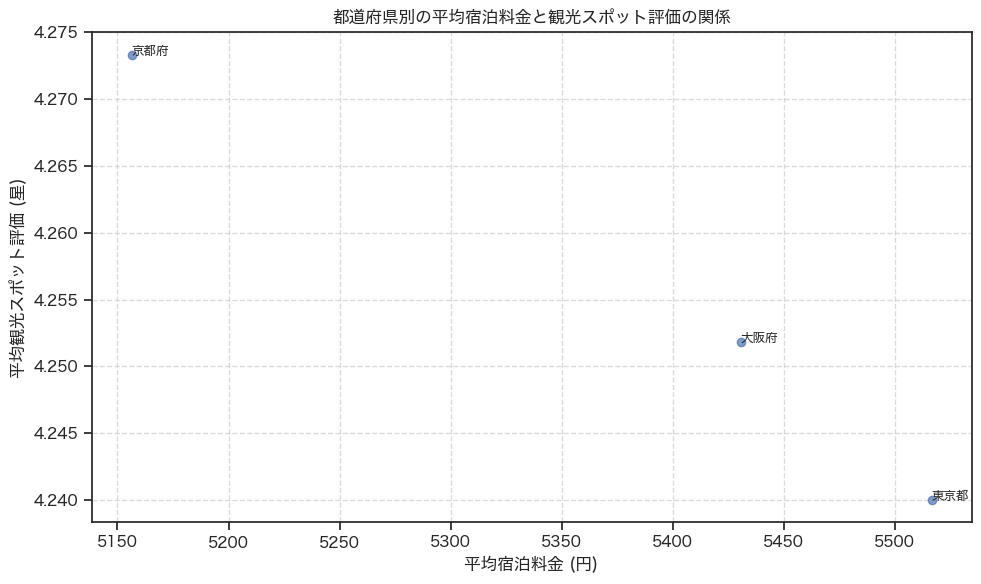


平均宿泊料金と平均観光スポット評価の相関係数: -0.992
注意：データポイントが3件と少ないため、相関係数の信頼性は高くありません。
⭕ 平均宿泊料金と観光スポット評価の間には強い負の相関関係がみられます。
　 観光スポットの評価が高い地域ほど宿泊料金が低い傾向があります。

仮説2の検証：観光スポット数・宿泊施設数と宿泊料金の関係

データの基本統計：
       attraction_count  hotel_count    avg_price
count               3.0          3.0     3.000000
mean               30.0         30.0  5367.811111
std                 0.0          0.0   188.129135
min                30.0         30.0  5156.333333
25%                30.0         30.0  5293.433333
50%                30.0         30.0  5430.533333
75%                30.0         30.0  5473.550000
max                30.0         30.0  5516.566667

観光スポット数の標準偏差：0.0
宿泊施設数の標準偏差：0.0
平均宿泊料金の標準偏差：188.12913512128196
観光スポット数と平均宿泊料金の相関係数を計算できません（標準偏差が0）
宿泊施設数と平均宿泊料金の相関係数を計算できません（標準偏差が0）

平均宿泊料金が高い上位5都道府県：
- 東京都：5517円 (観光スポット数：30, 宿泊施設数：30)
- 大阪府：5431円 (観光スポット数：30, 宿泊施設数：30)
- 京都府：5156円 (観光スポット数：30, 宿泊施設数：30)


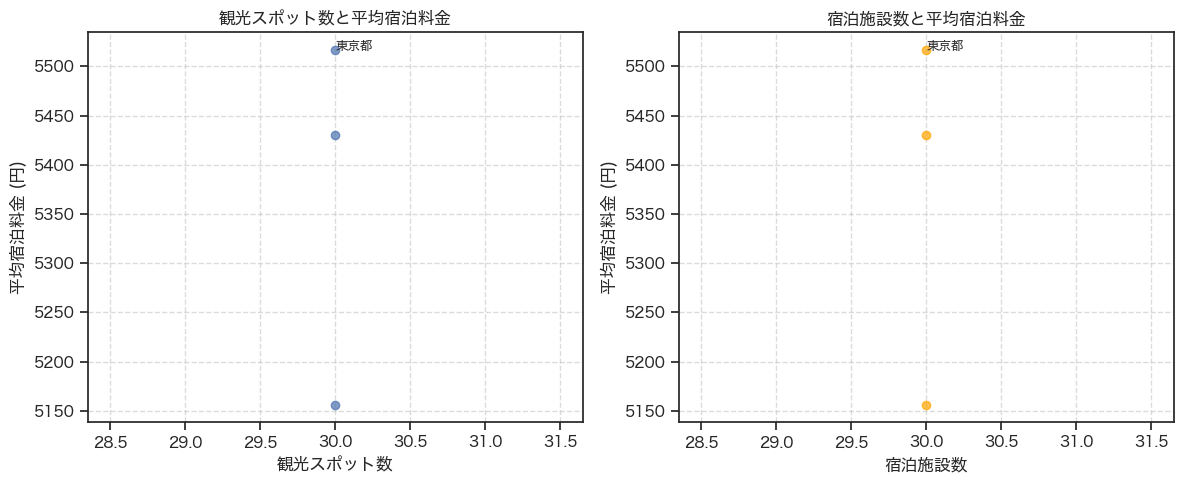


仮説2の検証結果：
- 観光スポット数と宿泊料金：相関係数を計算できませんでした
- 宿泊施設数と宿泊料金：相関係数を計算できませんでした
❌ 観光スポット数・宿泊施設数と宿泊料金の間に明確な相関は見られませんでした。
　 人気観光地だからといって必ずしも宿泊料金が高いわけではないようです。

総合的な結論
仮説1：宿泊料金と評価には負の相関関係があります。
     観光スポットの評価が高い地域では宿泊料金が低い傾向にあります。
仮説2：データ不足のため検証できませんでした。

データベース接続を閉じました。


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

# 日本語フォントの設定
plt.rcParams['font.family'] = 'Hiragino Sans'
plt.rcParams['axes.unicode_minus'] = False

class TravelDataAnalyzer:
    """旅行データを分析するクラス"""
    
    def __init__(self, db_path):
        """データベース接続を初期化"""
        try:
            self.conn = sqlite3.connect(db_path)
            print("データベースに接続しました。")
        except Exception as e:
            print(f"データベース接続エラー：{e}")
            self.conn = None

    def execute_query(self, query, params=()):
        """SQLクエリを実行し、結果をDataFrameで返す"""
        try:
            return pd.read_sql_query(query, self.conn, params=params)
        except Exception as e:
            print(f"クエリ実行エラー：{e}")
            print(f"実行されたクエリ：{query}")
            return pd.DataFrame()  # 空のDataFrameを返す
            
    def check_data(self):
        """データの存在確認と簡単な統計を表示"""
        print("\nデータ確認")
        
        # 宿泊施設データの確認
        acc_query = "SELECT COUNT(*) as count, COUNT(DISTINCT prefecture_code) as prefectures FROM accommodations"
        acc_data = self.execute_query(acc_query)
        print(f"宿泊施設データ：{acc_data['count'].iloc[0]}件 ({acc_data['prefectures'].iloc[0]}都道府県)")
        
        # 宿泊料金の統計
        price_query = """
        SELECT 
            COUNT(*) as total,
            COUNT(min_price) as price_count,
            AVG(min_price) as avg_price,
            MIN(min_price) as min_price,
            MAX(min_price) as max_price
        FROM accommodations
        """
        price_stats = self.execute_query(price_query)
        print(f"宿泊料金データ：{price_stats['price_count'].iloc[0]}件 (平均：{price_stats['avg_price'].iloc[0]:.1f}円)")
        print(f"料金範囲：{price_stats['min_price'].iloc[0]}円 〜 {price_stats['max_price'].iloc[0]}円")
        
        # 観光スポットデータの確認
        spot_query = "SELECT COUNT(*) as count, COUNT(DISTINCT prefecture_code) as prefectures FROM tourist_spots"
        spot_data = self.execute_query(spot_query)
        print(f"観光スポットデータ：{spot_data['count'].iloc[0]}件 ({spot_data['prefectures'].iloc[0]}都道府県)")
        
        # 評価の統計
        rating_query = """
        SELECT 
            COUNT(*) as total,
            COUNT(rating) as rating_count,
            AVG(rating) as avg_rating,
            MIN(rating) as min_rating,
            MAX(rating) as max_rating
        FROM tourist_spots
        """
        rating_stats = self.execute_query(rating_query)
        print(f"評価データ：{rating_stats['rating_count'].iloc[0]}件 (平均：{rating_stats['avg_rating'].iloc[0]:.2f})")
        print(f"評価範囲：{rating_stats['min_rating'].iloc[0]} 〜 {rating_stats['max_rating'].iloc[0]}")

    def analyze_price_rating_correlation(self):
        """仮説1: 宿泊料金と評価の相関関係を分析"""
        print("\n仮説1の検証：宿泊料金と評価の相関関係")
        
        # データのサンプルを確認
        sample_query = """
        SELECT 
            a.prefecture_code, 
            a.prefecture, 
            AVG(a.min_price) as avg_price,
            COUNT(a.id) as hotel_count,
            COUNT(t.id) as spot_count,
            AVG(t.rating) as avg_rating
        FROM 
            accommodations a
        JOIN 
            tourist_spots t ON a.prefecture_code = t.prefecture_code
        WHERE 
            a.min_price IS NOT NULL AND a.min_price > 0
            AND t.rating IS NOT NULL
        GROUP BY 
            a.prefecture_code, a.prefecture
        HAVING 
            hotel_count > 0 AND spot_count > 0
        ORDER BY 
            avg_price DESC
        LIMIT 5
        """
        
        sample_data = self.execute_query(sample_query)
        print("データサンプル：")
        display(sample_data)
        
        # 都道府県ごとの平均宿泊料金と平均評価を取得
        query = """
        SELECT 
            a.prefecture_code,
            a.prefecture,
            AVG(a.min_price) AS avg_price,
            COUNT(DISTINCT a.id) as hotel_count,
            COUNT(DISTINCT t.id) as spot_count,
            AVG(t.rating) AS avg_rating
        FROM 
            accommodations a
        JOIN 
            tourist_spots t ON a.prefecture_code = t.prefecture_code
        WHERE 
            a.min_price IS NOT NULL AND a.min_price > 0
            AND t.rating IS NOT NULL
        GROUP BY 
            a.prefecture_code, a.prefecture
        HAVING 
            hotel_count > 0 AND spot_count > 0
            AND avg_price IS NOT NULL AND avg_rating IS NOT NULL
        """
        
        df = self.execute_query(query)
        
        if df.empty:
            print("分析に必要なデータが取得できませんでした。")
            return None, None
        
        # データ型の変換
        df['avg_price'] = pd.to_numeric(df['avg_price'], errors='coerce')
        df['avg_rating'] = pd.to_numeric(df['avg_rating'], errors='coerce')
        df['hotel_count'] = pd.to_numeric(df['hotel_count'], errors='coerce')
        df['spot_count'] = pd.to_numeric(df['spot_count'], errors='coerce')
        
        # 欠損値の除去
        df = df.dropna(subset=['avg_price', 'avg_rating'])
        
        # データの分布を確認
        print("\nデータ分布の確認：")
        print(df[['avg_price', 'avg_rating', 'hotel_count', 'spot_count']].describe())
        
        # データポイントが不足している場合
        if len(df) < 3:
            print("有効なデータポイントが不足しています。少なくとも3つの都道府県データが必要です。")
            return df, None
        
        # データの分散を確認（標準偏差が0であれば相関係数が計算できない）
        price_std = df['avg_price'].std()
        rating_std = df['avg_rating'].std()
        
        print(f"\n価格の標準偏差：{price_std}")
        print(f"評価の標準偏差：{rating_std}")
        
        if price_std == 0 or rating_std == 0:
            print("警告：価格または評価の標準偏差が0です。相関係数を計算できません。")
            return df, None
        
        # 散布図
        plt.figure(figsize=(10, 6))
        plt.scatter(df['avg_price'], df['avg_rating'], alpha=0.7)
        
        # 都道府県名をプロット
        for i, row in df.iterrows():
            plt.annotate(row['prefecture'], 
                        (row['avg_price'], row['avg_rating']),
                        fontsize=9)
        
        plt.title('都道府県別の平均宿泊料金と観光スポット評価の関係')
        plt.xlabel('平均宿泊料金 (円)')
        plt.ylabel('平均観光スポット評価 (星)')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
        # 相関係数
        corr = df['avg_price'].corr(df['avg_rating'])
        print(f"\n平均宿泊料金と平均観光スポット評価の相関係数: {corr:.3f}")
        
        # 相関係数の信頼性チェック
        if len(df) < 10:
            print(f"注意：データポイントが{len(df)}件と少ないため、相関係数の信頼性は高くありません。")
        
        # 相関の解釈
        if abs(corr) > 0.7:
            strength = "強い"
        elif abs(corr) > 0.4:
            strength = "中程度の"
        elif abs(corr) > 0.2:
            strength = "弱い"
        else:
            strength = "ほとんどない"
            
        direction = "正の" if corr > 0 else "負の"
        
        if abs(corr) > 0.2:
            print(f"⭕ 平均宿泊料金と観光スポット評価の間には{strength}{direction}相関関係がみられます。")
            if corr > 0:
                print("　 観光スポットの評価が高い地域ほど宿泊料金も高い傾向があります。")
            else:
                print("　 観光スポットの評価が高い地域ほど宿泊料金が低い傾向があります。")
        else:
            print("❌ 平均宿泊料金と観光スポット評価の間には明確な相関関係はみられませんでした。")
        
        return df, corr

    def analyze_attraction_price_relationship(self):
        """仮説2: 観光スポット数・宿泊施設数と宿泊料金の関係を分析"""
        print("\n仮説2の検証：観光スポット数・宿泊施設数と宿泊料金の関係")
        
        # 都道府県ごとの集計データを取得
        query = """
        SELECT 
            a.prefecture_code, 
            a.prefecture,
            COUNT(DISTINCT a.id) as hotel_count,
            AVG(a.min_price) as avg_price,
            COUNT(DISTINCT t.id) as attraction_count
        FROM 
            accommodations a
        JOIN 
            tourist_spots t ON a.prefecture_code = t.prefecture_code
        WHERE 
            a.min_price IS NOT NULL AND a.min_price > 0
        GROUP BY 
            a.prefecture_code, a.prefecture
        HAVING 
            hotel_count > 0 AND attraction_count > 0
        """
        
        df = self.execute_query(query)
        
        if df.empty:
            print("分析に必要なデータが取得できませんでした。")
            return None, None, None
        
        # データ型の変換
        for col in ['attraction_count', 'hotel_count', 'avg_price']:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # 欠損値の除去
        df = df.dropna(subset=['attraction_count', 'hotel_count', 'avg_price'])
        
        # データの分布を確認
        print("\nデータの基本統計：")
        print(df[['attraction_count', 'hotel_count', 'avg_price']].describe())
        
        # データポイントが不足している場合
        if len(df) < 3:
            print("有効なデータポイントが不足しています。少なくとも3つの都道府県データが必要です。")
            return df, None, None
        
        # 分散を確認（標準偏差が0の場合、相関係数は計算できない）
        att_std = df['attraction_count'].std()
        hotel_std = df['hotel_count'].std()
        price_std = df['avg_price'].std()
        
        print(f"\n観光スポット数の標準偏差：{att_std}")
        print(f"宿泊施設数の標準偏差：{hotel_std}")
        print(f"平均宿泊料金の標準偏差：{price_std}")
        
        # 安全な相関係数の計算
        if att_std > 0 and price_std > 0:
            attraction_price_corr = df['attraction_count'].corr(df['avg_price'])
            print(f"観光スポット数と平均宿泊料金の相関係数：{attraction_price_corr:.3f}")
        else:
            attraction_price_corr = None
            print("観光スポット数と平均宿泊料金の相関係数を計算できません（標準偏差が0）")
        
        if hotel_std > 0 and price_std > 0:
            hotel_price_corr = df['hotel_count'].corr(df['avg_price'])
            print(f"宿泊施設数と平均宿泊料金の相関係数：{hotel_price_corr:.3f}")
        else:
            hotel_price_corr = None
            print("宿泊施設数と平均宿泊料金の相関係数を計算できません（標準偏差が0）")
        
        # 上位都道府県の表示
        print("\n平均宿泊料金が高い上位5都道府県：")
        top_df = df.sort_values('avg_price', ascending=False).head(5)
        for _, row in top_df.iterrows():
            print(f"- {row['prefecture']}：{row['avg_price']:.0f}円 (観光スポット数：{row['attraction_count']}, 宿泊施設数：{row['hotel_count']})")
        
        # 散布図（観光スポット数と宿泊料金）
        plt.figure(figsize=(12, 5))
        
        # 左側: 観光スポット数と料金の関係
        plt.subplot(1, 2, 1)
        plt.scatter(df['attraction_count'], df['avg_price'], alpha=0.7)
        
        # 相関係数が計算できる場合は回帰直線を追加
        if attraction_price_corr is not None:
            z = np.polyfit(df['attraction_count'], df['avg_price'], 1)
            p = np.poly1d(z)
            plt.plot(df['attraction_count'], p(df['attraction_count']), "r--", alpha=0.7)
        
        # 重要な地点にはラベルを付ける
        for i, row in df.iterrows():
            if row['attraction_count'] > df['attraction_count'].quantile(0.8) or row['avg_price'] > df['avg_price'].quantile(0.8):
                plt.annotate(row['prefecture'], 
                           (row['attraction_count'], row['avg_price']),
                           fontsize=9)
        
        plt.title('観光スポット数と平均宿泊料金')
        plt.xlabel('観光スポット数')
        plt.ylabel('平均宿泊料金 (円)')
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # 右側: 宿泊施設数と料金の関係
        plt.subplot(1, 2, 2)
        plt.scatter(df['hotel_count'], df['avg_price'], alpha=0.7, color='orange')
        
        # 相関係数が計算できる場合は回帰直線を追加
        if hotel_price_corr is not None:
            z = np.polyfit(df['hotel_count'], df['avg_price'], 1)
            p = np.poly1d(z)
            plt.plot(df['hotel_count'], p(df['hotel_count']), "r--", alpha=0.7)
        
        # 重要な地点にはラベルを付ける
        for i, row in df.iterrows():
            if row['hotel_count'] > df['hotel_count'].quantile(0.8) or row['avg_price'] > df['avg_price'].quantile(0.8):
                plt.annotate(row['prefecture'], 
                           (row['hotel_count'], row['avg_price']),
                           fontsize=9)
        
        plt.title('宿泊施設数と平均宿泊料金')
        plt.xlabel('宿泊施設数')
        plt.ylabel('平均宿泊料金 (円)')
        plt.grid(True, linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.show()
        
        # 仮説検証の結論
        print("\n仮説2の検証結果：")
        
        # 観光スポット数と宿泊料金の関係
        if attraction_price_corr is not None:
            if abs(attraction_price_corr) > 0.7:
                strength1 = "強い"
            elif abs(attraction_price_corr) > 0.4:
                strength1 = "中程度の"
            elif abs(attraction_price_corr) > 0.2:
                strength1 = "弱い"
            else:
                strength1 = "ほとんどない"
                
            direction1 = "正の" if attraction_price_corr > 0 else "負の"
            print(f"- 観光スポット数と宿泊料金：{strength1}{direction1}相関 (r={attraction_price_corr:.3f})")
        else:
            print("- 観光スポット数と宿泊料金：相関係数を計算できませんでした")
        
        # 宿泊施設数と宿泊料金の関係
        if hotel_price_corr is not None:
            if abs(hotel_price_corr) > 0.7:
                strength2 = "強い"
            elif abs(hotel_price_corr) > 0.4:
                strength2 = "中程度の"
            elif abs(hotel_price_corr) > 0.2:
                strength2 = "弱い"
            else:
                strength2 = "ほとんどない"
                
            direction2 = "正の" if hotel_price_corr > 0 else "負の"
            print(f"- 宿泊施設数と宿泊料金：{strength2}{direction2}相関 (r={hotel_price_corr:.3f})")
        else:
            print("- 宿泊施設数と宿泊料金：相関係数を計算できませんでした")
        
        # 総合的な結論
        correlation_found = False
        
        if attraction_price_corr is not None and abs(attraction_price_corr) > 0.2:
            correlation_found = True
            print("⭕ 観光スポット数と宿泊料金の間に相関関係が見られます。")
            if attraction_price_corr > 0:
                print("　 観光スポットが多い地域ほど宿泊料金が高い傾向があります。")
            else:
                print("　 観光スポットが多い地域ほど宿泊料金が低い傾向があります。")
        
        if hotel_price_corr is not None and abs(hotel_price_corr) > 0.2:
            correlation_found = True
            print("⭕ 宿泊施設数と宿泊料金の間に相関関係が見られます。")
            if hotel_price_corr > 0:
                print("　 宿泊施設が多い地域ほど宿泊料金が高い傾向があります。")
            else:
                print("　 宿泊施設が多い地域ほど宿泊料金が低い傾向があります。")
        
        if not correlation_found:
            print("❌ 観光スポット数・宿泊施設数と宿泊料金の間に明確な相関は見られませんでした。")
            print("　 人気観光地だからといって必ずしも宿泊料金が高いわけではないようです。")
            
        return df, attraction_price_corr, hotel_price_corr
    
    def close(self):
        """データベース接続を閉じる"""
        if self.conn:
            self.conn.close()
            print("\nデータベース接続を閉じました。")


# 使用例
if __name__ == "__main__":
    analyzer = TravelDataAnalyzer('jalan_travel_data.db')
    
    # データの確認
    analyzer.check_data()
    
    # 仮説1の検証: 宿泊料金と評価の関係
    acc_df, price_rating_corr = analyzer.analyze_price_rating_correlation()
    
    # 仮説2の検証: 観光スポット数・宿泊施設数と宿泊料金の関係
    pref_df, attraction_price_corr, hotel_price_corr = analyzer.analyze_attraction_price_relationship()
    
    # 総合的な結論
    print("\n総合的な結論")
    
    # 仮説1の結論
    if price_rating_corr is not None:
        if abs(price_rating_corr) > 0.2:
            direction = "正の" if price_rating_corr > 0 else "負の"
            print(f"仮説1：宿泊料金と評価には{direction}相関関係があります。")
            if price_rating_corr > 0:
                print("     観光スポットの評価が高い地域では宿泊料金も高い傾向にあります。")
            else:
                print("     観光スポットの評価が高い地域では宿泊料金が低い傾向にあります。")
        else:
            print("仮説1：宿泊料金と評価には明確な相関関係は見られませんでした。")
    else:
        print("仮説1：データ不足のため検証できませんでした。")
    
    # 仮説2の結論
    if attraction_price_corr is not None or hotel_price_corr is not None:
        correlation_found = False
        
        if attraction_price_corr is not None and abs(attraction_price_corr) > 0.2:
            correlation_found = True
            direction = "正の" if attraction_price_corr > 0 else "負の"
            print(f"仮説2(a)：観光スポット数と宿泊料金には{direction}相関関係があります。")
        
        if hotel_price_corr is not None and abs(hotel_price_corr) > 0.2:
            correlation_found = True
            direction = "正の" if hotel_price_corr > 0 else "負の"
            print(f"仮説2(b)：宿泊施設数と宿泊料金には{direction}相関関係があります。")
        
        if not correlation_found:
            print("仮説2：観光スポット数・宿泊施設数と宿泊料金の間に明確な関係は見られませんでした。")
    else:
        print("仮説2：データ不足のため検証できませんでした。")
    
    # 接続を閉じる
    analyzer.close()